In [1]:
import seaborn as sns
sns.set()

# Beyond $K$-Means

##  A problem with $K$-Means clustering

Consider applying $K$-means clustering to a data set where points are clustered in elongated shapes. We can visualize the data and manually identify the clusters. Let's see what happens when we try to use $K$-means with a data set consisting of points arranged in elongated shapes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

def elongated(clustering=None):
    X, _ = make_blobs(n_samples=300, n_features=2, cluster_std=0.5, random_state=0)

    # elongate the data
    Xt = np.dot(X, [[0.6, -0.64], [-0.4, 0.9]])

    if clustering is None:
        plt.scatter(*Xt.T, cmap='viridis')
    else:
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(Xt)
        clusters = kmeans.predict(Xt)
        plt.scatter(*Xt.T, c=clusters, cmap='viridis');
        
interact(elongated, clustering=[None, 'K-means']);

interactive(children=(Dropdown(description='clustering', options=(None, 'K-means'), value=None), Output()), _d…

$K$-Means did not identify what we might consider are the "obvious" clusters in the data set. Remember, in this case that the clusters are chosen to reduce *inertia*, which is a measure of how coherent the clusters are, i.e. given a value $K$ for the number of clusters, $K$-Means assigns a collection of clusters $C_k$ that minimize

$$ \mbox{argmin}_C \sum_{k=1}^K \sum_{X_j \in C_k} \| X_{j\cdot} - \mu_k \|^2 $$

where $\mu_k$ is the centroid of the points in $C_k$.  

This particular minimization problem results in *isotropic clusters* (i.e. clusters which are "balls" around their centroids).  If we desire to find clusters that might have different shapes, we need to change the way we define a clustering and how we assign points to the clusters.

## Gaussian mixture models

Gaussian mixture models (GMMs) are an alternative to the $K$-Means clustering. As seen previously, $K$-Means fails to define clusters of elongated shapes. Gaussian mixture models offer additional capabilities compared to $K$-Means. Cluster definitions are *probabilistic* and GMMs can model elongated shapes. GMMs define a probability density function over the feature space defined by adding or "mixing" several multivariate Gaussians.

To understand Gaussian mixture models, let's first define and plot a multivariate Gaussian. A multivariate Gaussian is simply a Gaussian distribution for more than one dimension. As with the one-dimensional Gaussian, it has two parameters. The mean $\mu$ is now a vector since we have multiple dimensions, and the variance has been replaced with the covariance matrix. Not only does the covariance matrix control how spread out the distribution is but also how correlated the variables are. If the variables are highly correlated, then the distribution will looked stretched. The covariance matrix contains all possible pairwise covariance values for all variables. For a two-dimensional case the covariance matrix itself has three different parameters, the variance of each variable, $\sigma^2_{x}$ and $\sigma^2_{y}$ and the covariance between the two variables $\mathrm{cov}(x, y)$.

$$ \Sigma = \left[ \begin{array}{cc} 
\sigma^2_{x} & \mathrm{cov}(x, y) \\
\mathrm{cov}(x, y) & \sigma^2_{y} \\
\end{array} \right]$$

Let's build an interactive plot where we can see the effect of modifying the covariance matrix for a bivariate Gaussian. We can adjust all three parameters involved in the covariance matrix. Note, the correlation coefficient $\rho$ is just a normalization of the covariance. In this case, it is equal to $\rho = \mathrm{cov}(x, y)/ (\sigma_{x} \sigma_{y})$.

In [3]:
from ipywidgets import FloatSlider
import scipy as sp

def multivariate_gaussian(corr=0, sigma_x=1, sigma_y=1):
    cov = sigma_x*sigma_y*np.array([[sigma_x/sigma_y, corr], [corr, sigma_y/sigma_x]])
    dist = sp.stats.multivariate_normal(mean=[0, 0], cov=cov)
    X = dist.rvs(1000, random_state=0)
    
    n = 100
    xlims = [-4, 4]
    ylims = [-4, 4]
    X1, X2 = np.meshgrid(np.linspace(*xlims, n), np.linspace(*ylims, n))
    proba = dist.pdf(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
    
    plt.scatter(*X.T, alpha=0.25)
    plt.contour(X1, X2, proba.reshape(100, 100))
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel('$x$')
    plt.ylabel('$y$')

corr_slider = FloatSlider(min=-0.99, max=0.99, value=0., step=0.01, description='$\\rho$')
sigma_x_slider = FloatSlider(min=0.5, max=1.5, value=1., step=0.01, description='$\sigma_x$')
sigma_y_slider = FloatSlider(min=0.5, max=1.5, value=1., step=0.01, description='$\sigma_y$')
interact(multivariate_gaussian, corr=corr_slider, sigma_x=sigma_x_slider, sigma_y=sigma_y_slider);

interactive(children=(FloatSlider(value=0.0, description='$\\rho$', max=0.99, min=-0.99, step=0.01), FloatSlid…

Notice how the covariance matrix controls the elongation of the distribution. It is this "stretching" capability that enables Gaussian mixture models to create anisotropic clusters. The probability across our feature space is defined as

$$ p(x_j) = \sum_k \phi_k \mathcal{N}(x_j; \mu_k, \Sigma_k), $$
where $\mathcal{N}(x_j; \mu_k, \Sigma_k)$ is a multivariate Gaussian parameterized by $\mu_k$ and $\Sigma_k$. When we fit a mixture model to a training set, we are trying to determine $\phi_k$, $\mu_k$, and $\Sigma_k$ that will maximize the likelihood function

$$ L(\phi_k, \mu_k, \Sigma_k) =  \prod_j p(x_j).$$
The most common algorithm used to fit Gaussian mixture models is the expectation-maximization algorithm, a two-step iterative scheme. More about the algorithm can be read [here](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). As with complicated models, the additional complexity results in slower training times and Gaussian mixture models will be difficult to train with large data sets.

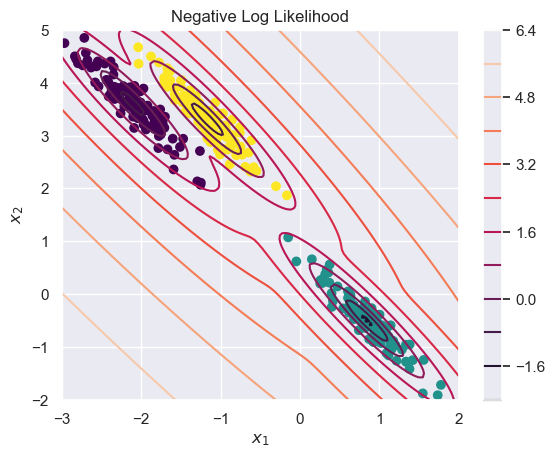

In [4]:
from sklearn.mixture import GaussianMixture

X, _ = make_blobs(n_samples=300, n_features=2, cluster_std=0.5, random_state=0)
Xt = np.dot(X, [[0.6, -0.64], [-0.4, 0.9]])

gm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gm.fit(Xt)
clusters = gm.predict(Xt)

xlims = [-3, 2]
ylims = [-2, 5]
X1, X2 = np.meshgrid(np.linspace(*xlims, 100), np.linspace(*ylims, 100))
proba = gm.score_samples(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))

plt.contour(X1, X2, np.log(-proba.reshape(100, 100)), 10)
plt.colorbar()
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(*Xt.T, c=clusters, cmap='viridis')
plt.title('Negative Log Likelihood');

The GMM is able to identify the three "natural" clusters in our example above.  

The `predict_proba` method of the `GaussianMixture` class gives probabilistic predictions of a sample belonging to each class.  We can turn the probabilistic predictions of GMMs into a "hard" clustering algorithm by predicting to the cluster with largest probability, and this is what the `predict` method of `GaussianMixture` does.  

1. For K-Means, what happens if the features have very different scales?

For K-Means, the largest-scaled feature will dominate the clustering. If the features have very different scales you should normalize the data first.

2. Does this problem exist for Gaussian Mixture Models?
This problem does not exist for Gaussian Mixture Models. In the 2D case (two features), the curves of constant probability are ellipses whose major and minor axes are dictated by the eigenvalues and eigenvectors of the covariance matrix,  Σ . 2D  𝐾 -Means clusters, on the other hand, are assumed to be circular.